# Modeling and Predictions

[Notebook 1: EDA and Cleaning](./1_EDA and Cleaning.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling and Predictions.ipynb)

1. Features
2. Resampling
3. Modeling
    - Scaling
    - Lagged features
    - Train test split, fit models, evaluate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

import time

import matplotlib
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

from tqdm import tqdm

from sklearn.metrics import mean_squared_error, r2_score
from numpy import sqrt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

/Users/sam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
matplotlib.rcParams['figure.figsize'] = (13, 8)

In [3]:
# Read in pickle.
data = pd.read_pickle('./pickle.pkl')

# Features

In [4]:
# Add hours feature
data['Hour'] = data.index.hour

In [5]:
# Get features
features = ['DOY', 'DNI', 'Air Temp', 'Hour', 'Humidity', 'Pressure', 'Wind Speed', 'Wind Dir']
label = ['DNI']

# Resampling
Resampling data to reduce runtime. Resampling during the period where the battery did not hold a charge, we see the  missing raw data.

In [6]:
data_re = data[features].resample('60T').mean()

In [7]:
data_re.sort_index(inplace=True)

In [8]:
print(data_re[data_re['DNI'].isnull()])

                     DOY  DNI  Air Temp  Hour  Humidity  Pressure  Wind Speed  \
datetime                                                                        
2014-12-03 19:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 20:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 21:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 22:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 23:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-04 00:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-04 01:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-04 02:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-04 03:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-04 04:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-04 05:00:00  NaN  Na

In [9]:
data_re.dropna(axis=0, inplace=True)

# Modeling

## Scaling

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data_re)
scaled = pd.DataFrame(scaled, index=data_re.index, columns=data_re.columns)

## Lagged features

In [11]:
# Create df of all lagged features

lags = [24, 72, 168]
lstm_data = pd.DataFrame()
lagged_feat_dict = {}

for x in lags:
    
    # shift
    lagged_data = scaled[features].shift(periods=x).dropna() # drop after looping
    
    # rename lagged features
    lagged_col_names = {}
    for y in lagged_data.columns:
        lagged_col_names[y] = y + '_' + str(x)
    lagged_data.rename(columns=lagged_col_names, inplace=True)
    
    # make dict of lagged_col_names (to reference for later)
    lagged_feat_dict[x] = lagged_col_names.values()
        
    # make lstm_data the lagged data
    lstm_data = pd.concat([lstm_data, lagged_data], axis=1)
    
# Add DNI target
lstm_data = pd.concat([lstm_data, scaled[label]], axis=1)

## Train test split, fit models, evaluate

Training w/ lag 24 hours:
Train on 23992 samples, validate on 19576 samples
Epoch 1/5
23992/23992 [==============================] - 33s 1ms/step - loss: 0.0547 - val_loss: 0.0477
Epoch 2/5
23992/23992 [==============================] - 31s 1ms/step - loss: 0.0504 - val_loss: 0.0470
Epoch 3/5
23992/23992 [==============================] - 31s 1ms/step - loss: 0.0496 - val_loss: 0.0465
Epoch 4/5
23992/23992 [==============================] - 31s 1ms/step - loss: 0.0489 - val_loss: 0.0456
Epoch 5/5
23992/23992 [==============================] - 32s 1ms/step - loss: 0.0481 - val_loss: 0.0449


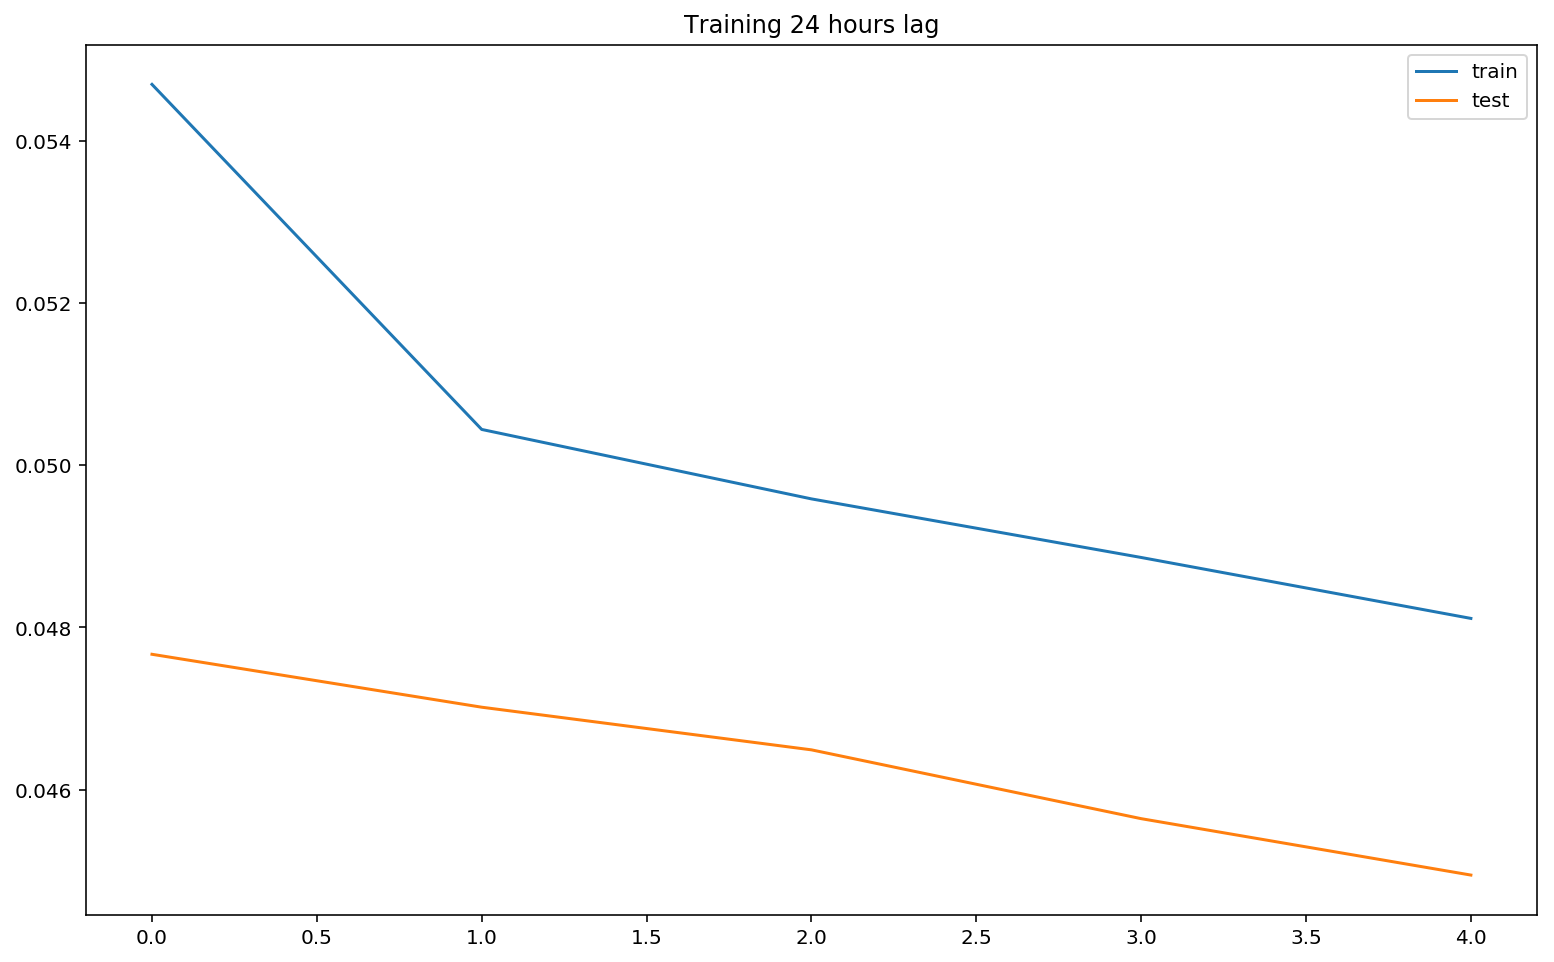

RMSE in DNI (W/m2): 218.922


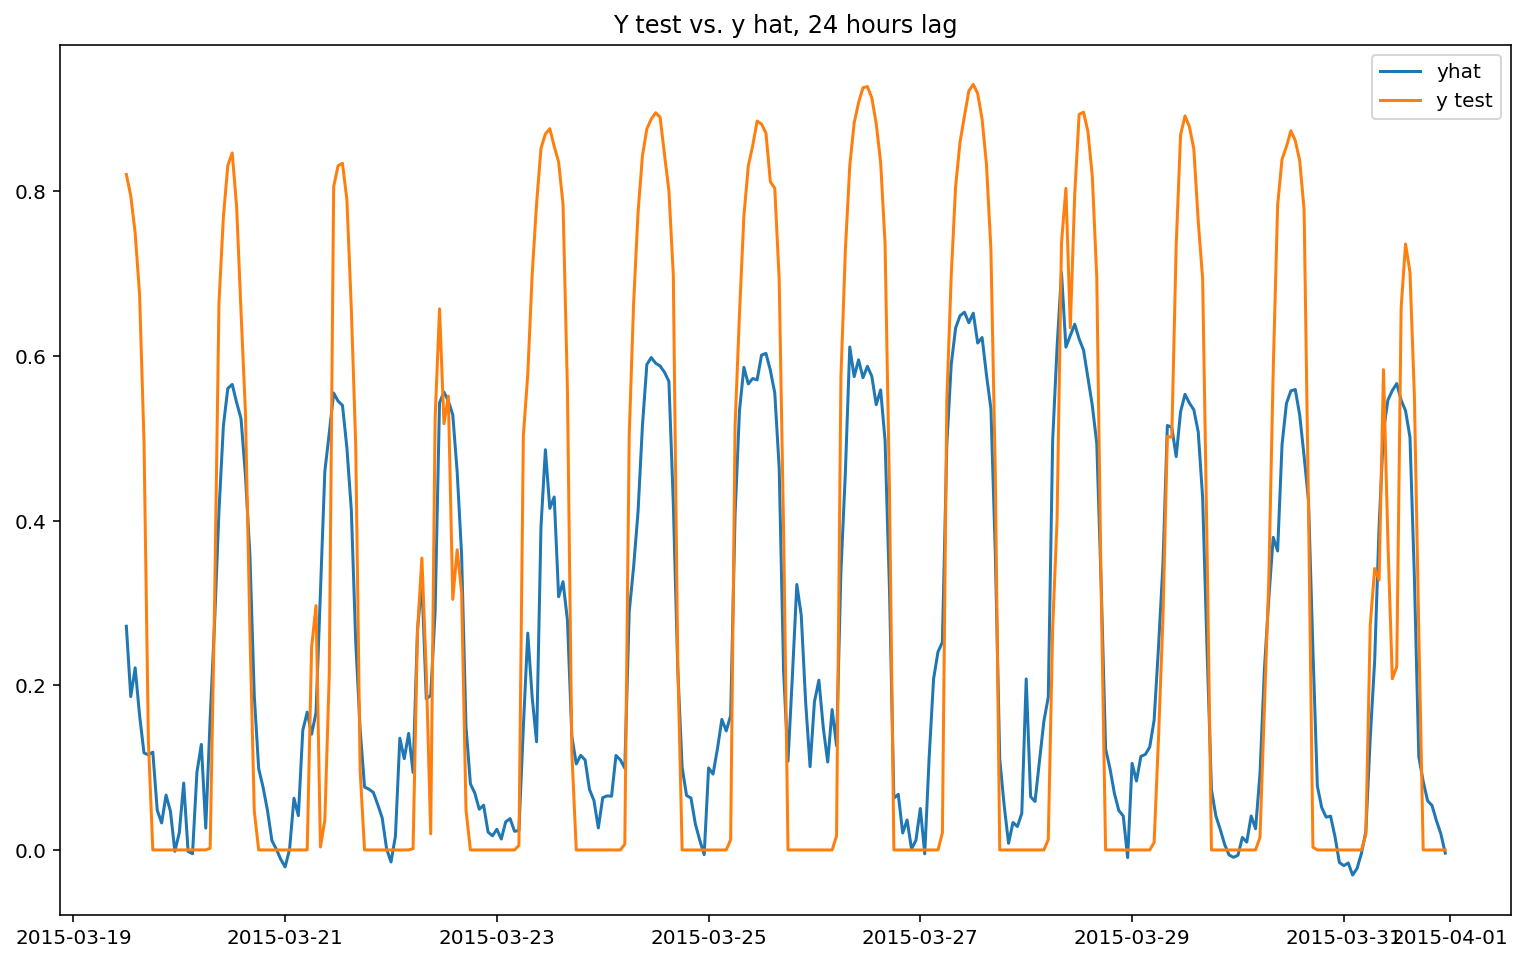

24 hours lag test R2 score: 0.029
24 hours lag test RMSE: 0.212

Training w/ lag 72 hours:
Train on 23944 samples, validate on 19576 samples
Epoch 1/5
23944/23944 [==============================] - 43s 2ms/step - loss: 0.0697 - val_loss: 0.0699
Epoch 2/5
23944/23944 [==============================] - 41s 2ms/step - loss: 0.0649 - val_loss: 0.0649
Epoch 3/5
23944/23944 [==============================] - 42s 2ms/step - loss: 0.0603 - val_loss: 0.0624
Epoch 4/5
23944/23944 [==============================] - 42s 2ms/step - loss: 0.0588 - val_loss: 0.0599
Epoch 5/5
23944/23944 [==============================] - 42s 2ms/step - loss: 0.0578 - val_loss: 0.0592


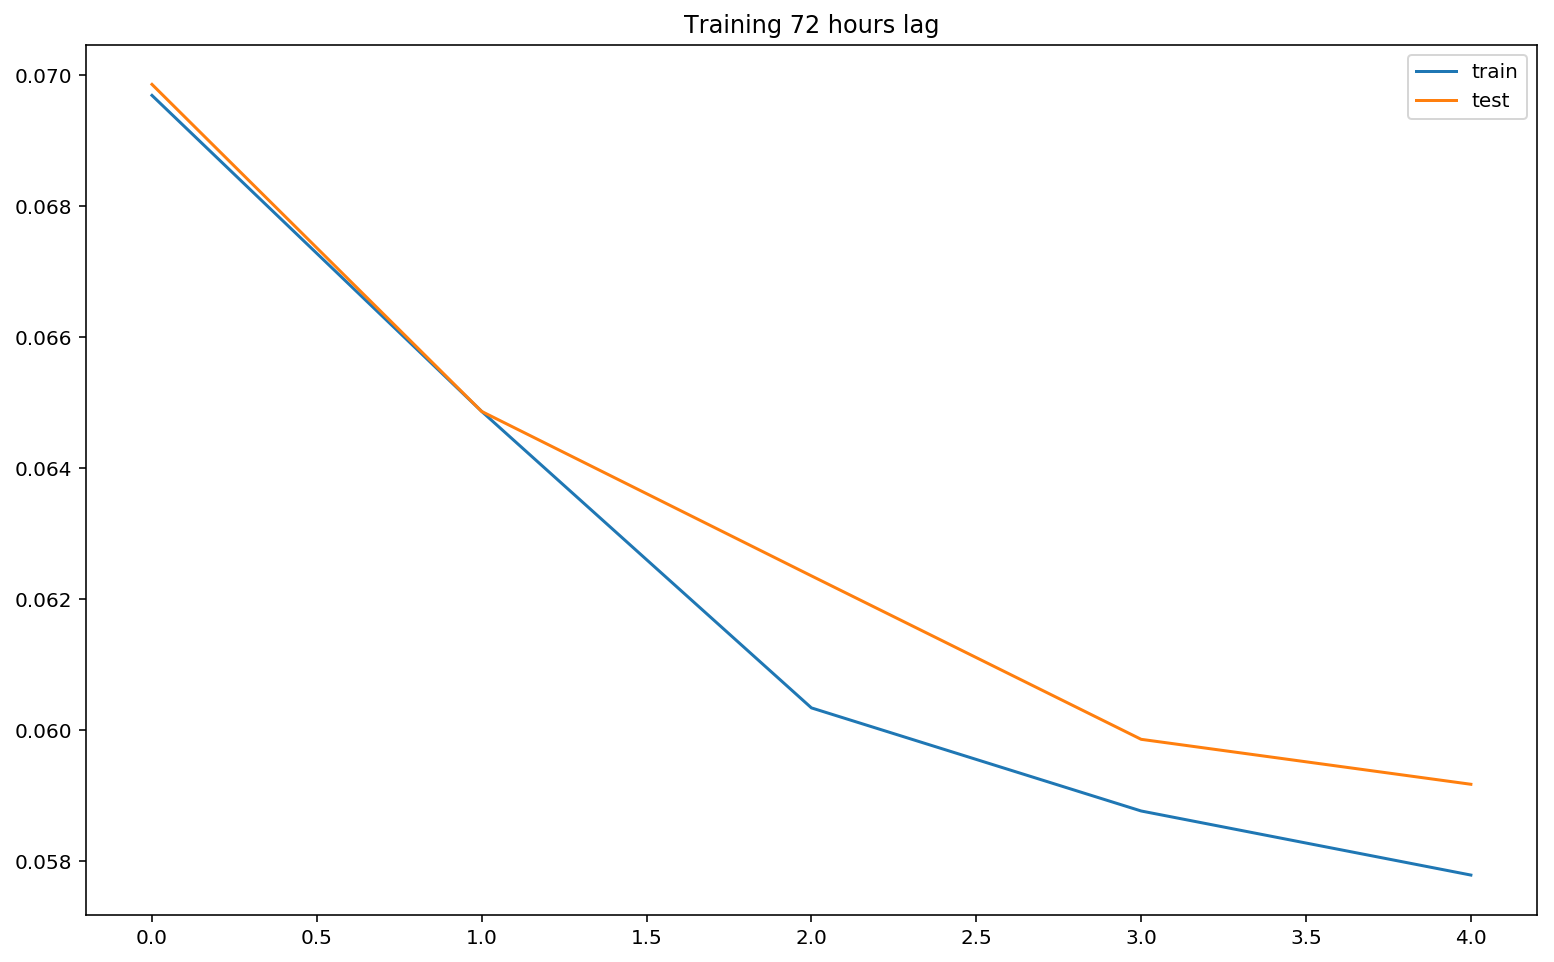

RMSE in DNI (W/m2): 251.197


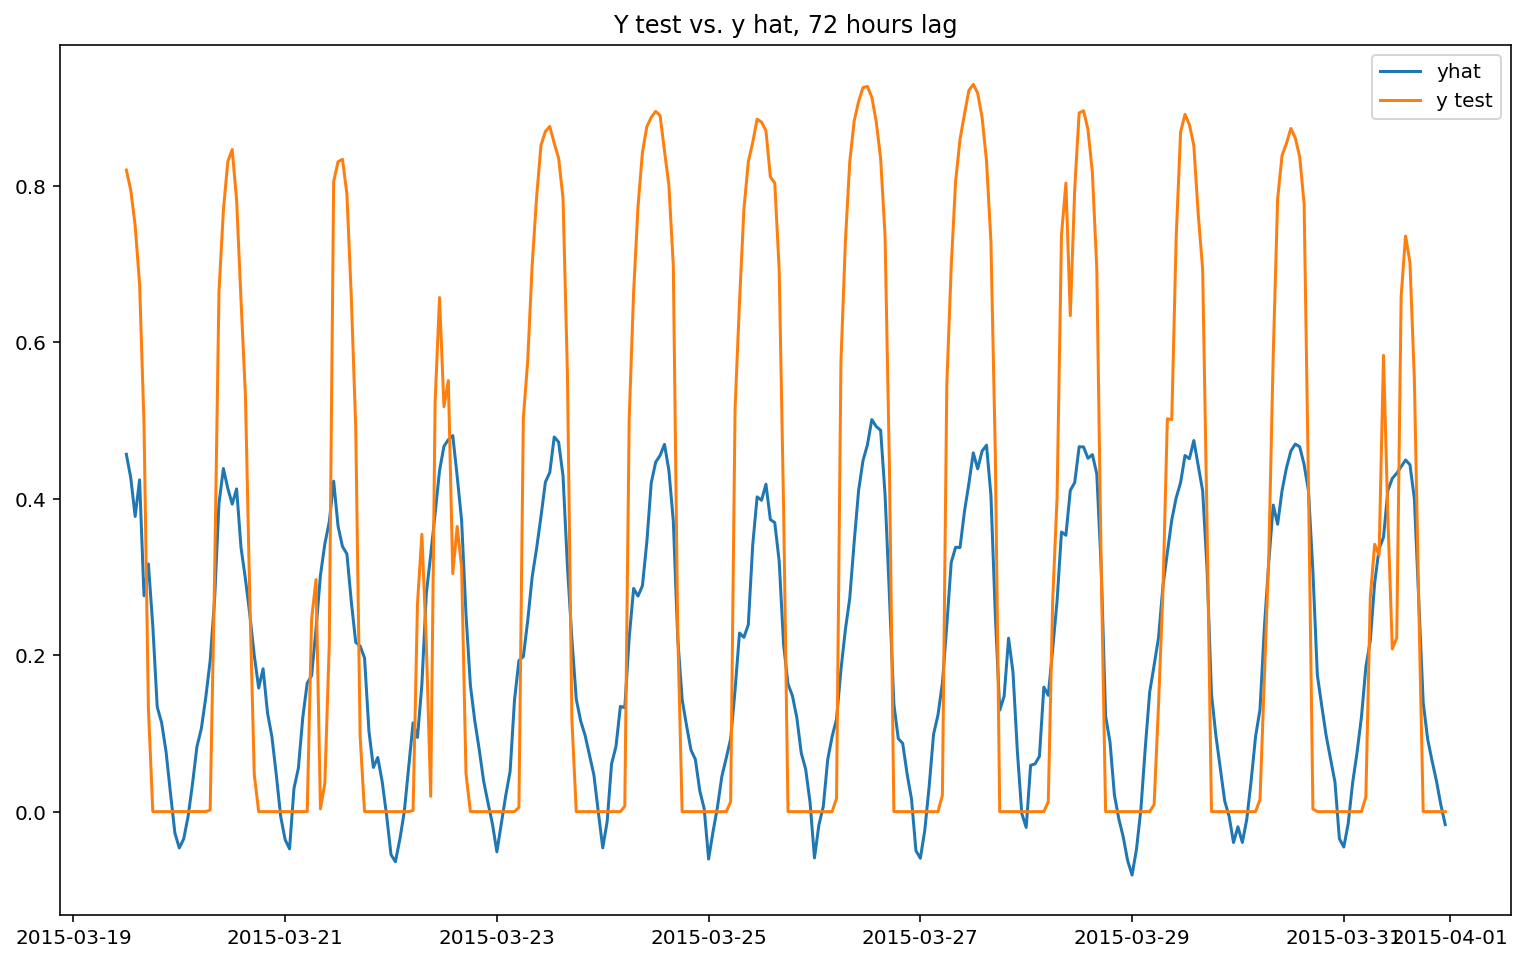

72 hours lag test R2 score: -0.860
72 hours lag test RMSE: 0.243

Training w/ lag 168 hours:
Train on 23848 samples, validate on 19576 samples
Epoch 1/5
23848/23848 [==============================] - 81s 3ms/step - loss: 0.0699 - val_loss: 0.0680
Epoch 2/5
23848/23848 [==============================] - 80s 3ms/step - loss: 0.0669 - val_loss: 0.0636
Epoch 3/5
23848/23848 [==============================] - 80s 3ms/step - loss: 0.0616 - val_loss: 0.0631
Epoch 4/5
23848/23848 [==============================] - 80s 3ms/step - loss: 0.0598 - val_loss: 0.0634
Epoch 5/5
23848/23848 [==============================] - 81s 3ms/step - loss: 0.0594 - val_loss: 0.0634


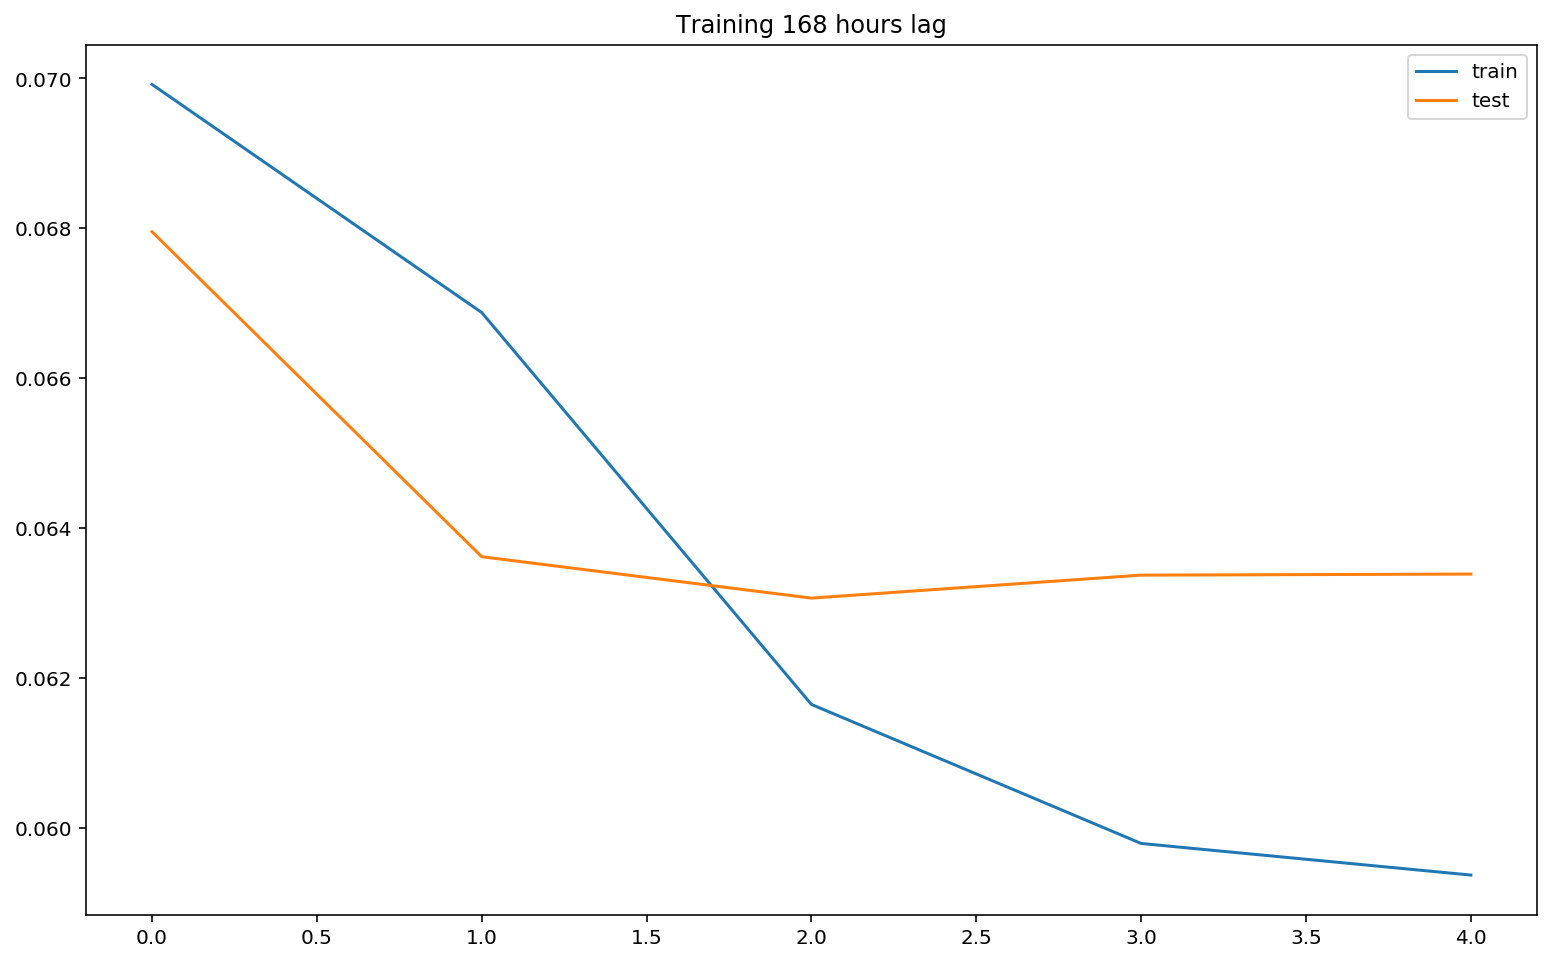

RMSE in DNI (W/m2): 259.981


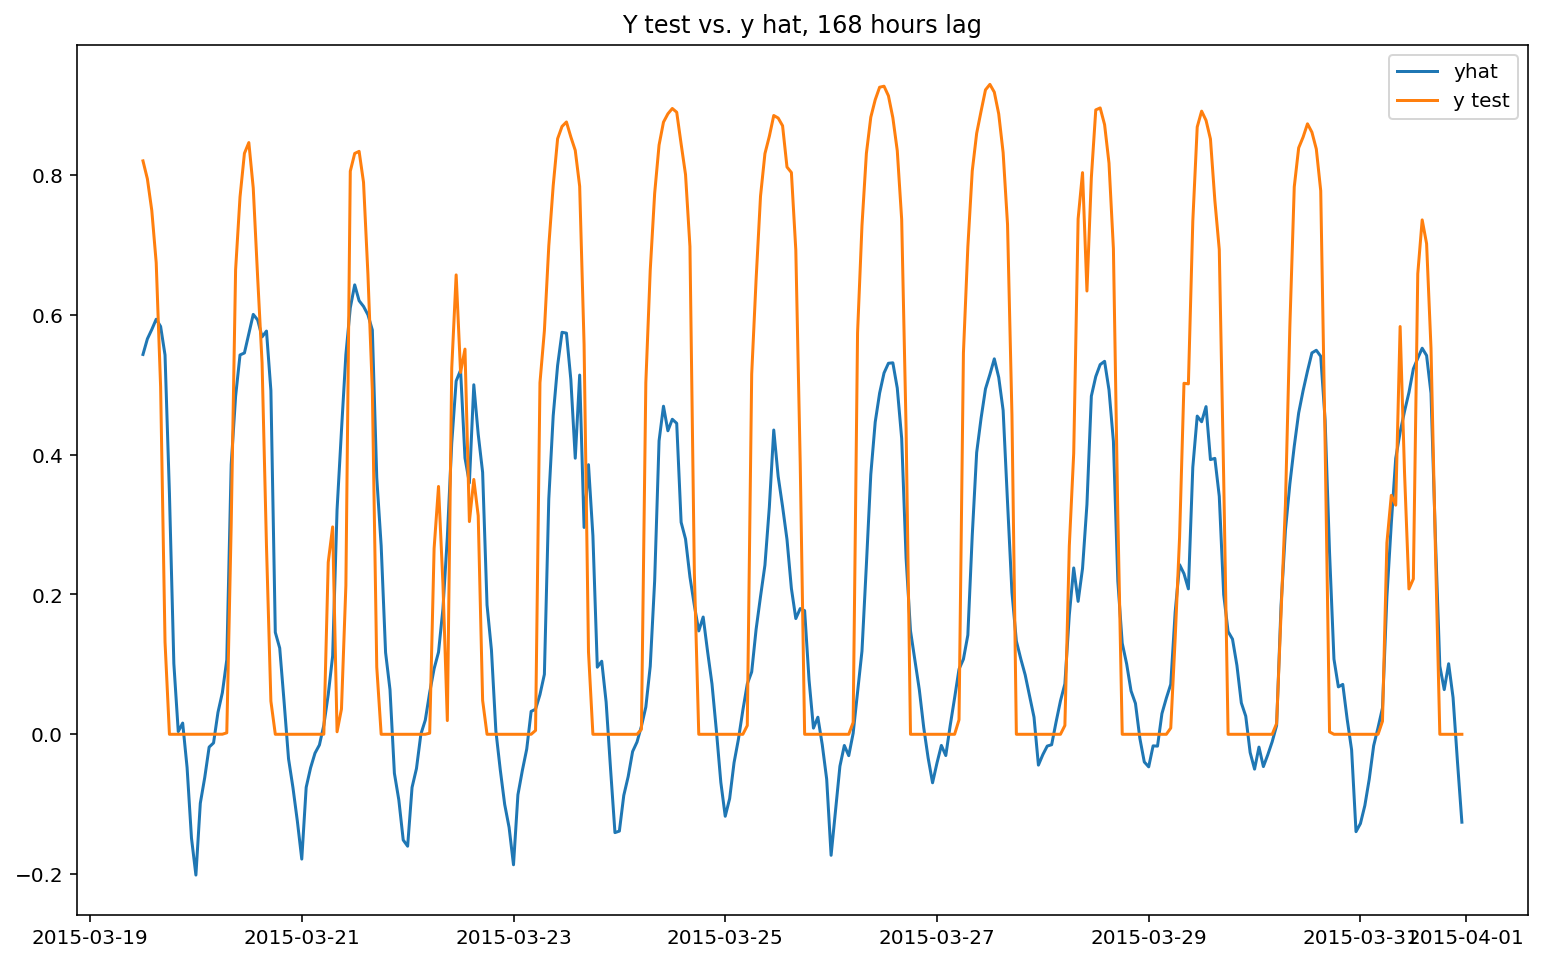

168 hours lag test R2 score: -0.277
168 hours lag test RMSE: 0.252



In [12]:
year = 2013

tts = len(lstm_data.loc[lstm_data.index.year < year])

model_results = []

epochs_ = 5
batch_size_ = 3
dropout_ = .33

for x in lags:
    
    print('Training w/ lag', x, 'hours:')
    
    feats = list(lagged_feat_dict[x])
    
    lstm_temp = lstm_data[feats + ['DNI']].dropna()
    lstm_train = lstm_temp.loc[lstm_temp.index.year < year]
    lstm_test = lstm_temp.loc[lstm_temp.index.year >= year]
    
    X_train = lstm_train[feats].values
    X_test = lstm_test[feats].values
    y_train = lstm_train['DNI'].values
    y_test = lstm_test['DNI'].values
    
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        
    # design network
    model = Sequential()
    model.add(LSTM(int(x), input_shape=(X_train.shape[1], X_train.shape[2]))) # num cells
    model.add(Dropout(dropout_))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit network
    history = model.fit(X_train, 
                        y_train, 
                        epochs=epochs_, 
                        batch_size=batch_size_, 
                        validation_data=(X_test, y_test), 
                        verbose=1, 
                        shuffle=False)
    
    # Save model for later
    filename = str(int(time.time())) + '_model_' + str(x) + '_lag.h5'
    model.save('./models/' + filename)
    
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Training ' + str(x) + ' hours lag')
    plt.show()

    # make a prediction
    yhat = model.predict(X_test)
    
    # Concat y_hat to dataframe for later
    lstm_test = pd.concat([lstm_test, pd.DataFrame(yhat, columns=['yhat'], index=lstm_test.index)], axis=1)
    
    # Invert scaling (so we can get our forecast and evaluation in terms of DNI (W/m2))

    # Get yhat and y_test
    yhat = lstm_test['yhat']
    original = lstm_test['DNI']

    # Copy lstm_test
    lstm_test_yhat = lstm_test.iloc[:, :8]
    lstm_test_original = lstm_test.iloc[:, :8]

    # Substitute yhat and y_test into lstm_test
    lstm_test_yhat.iloc[:, 1] = yhat
    lstm_test_original.iloc[:, 1] = original

    # Inverse yhat
    inv_yhat = scaler.inverse_transform(lstm_test_yhat)
    inv_yhat = pd.DataFrame(inv_yhat).iloc[:, 1]

    # Inverse y_test
    inv_y_test = scaler.inverse_transform(lstm_test_original)
    inv_y_test = pd.DataFrame(inv_y_test).iloc[:, 1]
    
    # Average RMSE, in terms of DNI (W/m2)
    print('RMSE in DNI (W/m2): %.3f' % sqrt(mean_squared_error(inv_y_test, inv_yhat)))
          
    hours = 300

    plt.plot(yhat[-hours:], label='yhat')
    plt.plot(original[-hours:], label='y test')
    plt.legend()
    plt.title('Y test vs. y hat, ' + str(x) + ' hours lag')
    
    plt.show()
    
    # # calculate RMSE
    rmse = sqrt(mean_squared_error(yhat, y_test))
    r2 = r2_score(yhat, y_test)
    print(str(x) + ' hours lag test R2 score: %.3f' % r2)
    print(str(x) + ' hours lag test RMSE: %.3f' % rmse)
    print()
    
    # Save all the results
    
    model_results_dict = {}
    
    model_results_dict['tts_year'] = year
    model_results_dict['lag'] = x
    model_results_dict['dropout'] = dropout_
    model_results_dict['epochs'] = epochs_
    model_results_dict['batch_size'] = batch_size_
    model_results_dict['params'] = history.params
    model_results_dict['loss'] = history.history
    model_results_dict['rmse'] = rmse
    model_results_dict['dni_rmse'] = sqrt(mean_squared_error(inv_y_test, inv_yhat))
    model_results_dict['r2'] = r2
    model_results_dict['model_filename'] = filename
    model_results_dict['time_ran'] = int(time.time())
    
    model_results.append(model_results_dict)
    
# Reads in old results and concats with new results

new_res_df = pd.DataFrame(model_results)
old_res_df = pd.read_csv('./results/results.csv', index_col=0)
res_df = pd.concat([old_res_df, new_res_df], axis=0, sort=False).reset_index(drop=True)
res_df.to_csv('./results/results.csv')

In [13]:
res_df

,batch_size,dni_rmse,dropout,epochs,lag,loss,model_filename,params,r2,rmse,time_ran,tts_year
0,1000,NaN,0.30,2,24,"{'val_loss': [0.1319106151001746, 0.0975300812...",model_24_lag_1539828685.h5,"{'batch_size': 1000, 'epochs': 2, 'steps': Non...",-27.727080,0.312298,NaN,2012
1,1000,NaN,0.30,2,72,"{'val_loss': [0.09933691712461507, 0.089069512...",model_72_lag_1539828700.h5,"{'batch_size': 1000, 'epochs': 2, 'steps': Non...",-19.836728,0.298445,NaN,2012
2,1000,NaN,0.30,2,168,"{'val_loss': [0.10483372032810502, 0.091769528...",model_168_lag_1539828724.h5,"{'batch_size': 1000, 'epochs': 2, 'steps': Non...",-23.785155,0.302935,NaN,2012
3,1000,334.279995,0.30,2,24,"{'val_loss': [0.11410914926838303, 0.104791953...",model_24_lag_1539829201.h5,"{'batch_size': 1000, 'epochs': 2, 'steps': Non...",-68.720157,0.323716,1.539829e+09,2012
4,1000,321.314559,0.30,2,72,"{'val_loss': [0.10655641882602855, 0.096820642...",model_72_lag_1539829218.h5,"{'batch_size': 1000, 'epochs': 2, 'steps': Non...",-37.384210,0.311160,1.539829e+09,2012
5,1000,315.801188,0.30,2,168,"{'val_loss': [0.10708953705005485, 0.093526501...",model_168_lag_1539829242.h5,"{'batch_size': 1000, 'epochs': 2, 'steps': Non...",-30.933305,0.305821,1.539829e+09,2012
6,1000,315.450079,0.30,2,24,"{'val_loss': [0.1021212695957239, 0.0933186499...",1539829385_model_24_lag.h5,"{'batch_size': 1000, 'epochs': 2, 'steps': Non...",-31.481260,0.305481,1.539829e+09,2012
7,1000,324.799402,0.30,2,72,"{'val_loss': [0.10990308506784721, 0.098932185...",1539829403_model_72_lag.h5,"{'batch_size': 1000, 'epochs': 2, 'steps': Non...",-47.179091,0.314535,1.539829e+09,2012
8,1000,320.735760,0.30,2,168,"{'val_loss': [0.1059515149725341, 0.0964721468...",1539829429_model_168_lag.h5,"{'batch_size': 1000, 'epochs': 2, 'steps': Non...",-36.393194,0.310600,1.539829e+09,2012
9,3,218.921948,0.33,5,24,"{'val_loss': [0.047669098476337116, 0.04701623...",1539831721_model_24_lag.h5,"{'batch_size': 3, 'epochs': 5, 'steps': None, ...",0.029331,0.212003,1.539832e+09,2013
